In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
# import sklearn.cross_validation   #新版为from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import stats
import statsmodels.api as sm
import copy
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("cs-training.csv")#把数据读入程序
print(df.shape)
print(df.columns)

(150000, 12)
Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')


In [3]:
df.head(5)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
# 初步看到数据第一列无意义、列名过长，后续使用会不便; 
# RevolvingUtilizationOfUnsecuredLines, age, DebtRatio, MonthlyIncome为连续性变量，其他为离散变量。
# 其中SeriousDlqin2yrs是我们需要研究的分类label，即y值，它是0/1变量，代表是否出现逾期偿还的坏情况。
# 因此，使用下面代码，删除第一列，将部分列名重新命名。
df = df.iloc[:,1:]#去除第一列
#重新命名列名
# 定义一个字典，将原始列名映射到新的列名
column_name_mapping = {
    'SeriousDlqin2yrs':'label',#信用评分和信用风险相关的一个变量，表示一个人在未来两年内是否会严重拖欠债务。0:无拖欠（优质客户），1：有拖欠
    'RevolvingUtilizationOfUnsecuredLines': 'lineofcredit',
    'NumberOfTime30-59DaysPastDueNotWorse': '30-59days',
    'NumberOfOpenCreditLinesAndLoans':'openloan',
    'NumberOfTimes90DaysLate':'90+days',
    'NumberRealEstateLoansOrLines':'estate',
    'NumberOfTime60-89DaysPastDueNotWorse':'60-89days',
    'NumberOfDependents':'family'
}
# 使用 rename() 方法重新命名列名
df.rename(columns=column_name_mapping, inplace=True)
df.head(5)

,label,lineofcredit,age,30-59days,DebtRatio,MonthlyIncome,openloan,90+days,estate,60-89days,family
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
# 接下来进行缺失值处理。数据缺失情况在现实问题中非常普遍，常见的处理方法包括： 
# 1. 直接删除有缺失值的样本；
# 2. 根据样本之间的相似性填补；
# 3. 根据变量之间的相关性填补。
# 首先查看缺失值。
print(df.isnull().sum())#查看缺失值

label                0
lineofcredit         0
age                  0
30-59days            0
DebtRatio            0
MonthlyIncome    29731
openloan             0
90+days              0
estate               0
60-89days            0
family            3924
dtype: int64


In [6]:
# 可以看到我们的特征还是比较完整的，只有两个变量有缺失的情况，分别是月收入（MonthlyIncome）和家属人数（family）。
# 其中， MonthlyIncome缺失数量较多，为29731个我们根据变量之间的相关关系，采用随机森林进行填补；
# family缺失数量较少，为3924个（小于样本总量的5%），直接删除这些样本；同时查看重复的值并删除。
#MonthlyIncome缺失值填补
data_copy = df.iloc[:,[5,0,1,2,3,4,6,7,8,9]]  
df_known = data_copy[data_copy.MonthlyIncome.notnull()] #对MonthlyIncome非空值进行筛选，df_known,即为训练集
df_unknown = data_copy[data_copy.MonthlyIncome.isnull()] #对MonthlyIncome空值进行筛选，生成df_unknown,即为测试集
train_X = df_known.iloc[:,1:] #首列5为MonthlyIncome，即为Y,其他为自变量X
train_Y = df_known.iloc[:,0]

In [7]:
# n_estimators: 决策树的数量，即森林中树木的数量。
# max_depth: 每棵树的最大深度
rf_model = RandomForestRegressor(random_state = 0, n_estimators = 200, max_depth = 3, n_jobs = 1)
rf_model.fit(train_X, train_Y)

RandomForestRegressor(max_depth=3, n_estimators=200, n_jobs=1, random_state=0)

In [8]:
predict_income=rf_model.predict(df_unknown.iloc[:,1:]).round(0) #用随机森林模型预测结果进行填补，并四舍五入到整数
predict_income

array([8311., 1159., 8311., ..., 1159., 2554., 2554.])

In [9]:
df.loc[df.MonthlyIncome.isnull(),'MonthlyIncome'] = predict_income
#缺失值和重复值删除
df = df.dropna()
df = df.drop_duplicates()

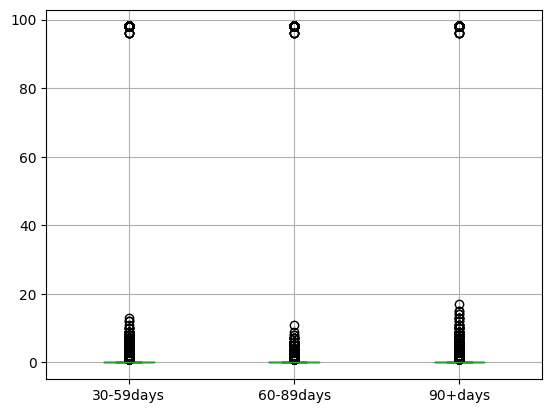

In [10]:
#对于属性30-59days，90+days，60-89days	三个属性绘制箱线图
box1 = df.iloc[:,[3,9,7]]  #3，7，9列为相同的单位，可以画在一张图中（注意py的index从0开始计）
box1.boxplot()
plt.show()
# 在30-59days, 60-89days, 90+days三个变量中，有两组样本偏离了其他分布，可以将其去除；


AxesSubplot(0.125,0.11;0.775x0.77)


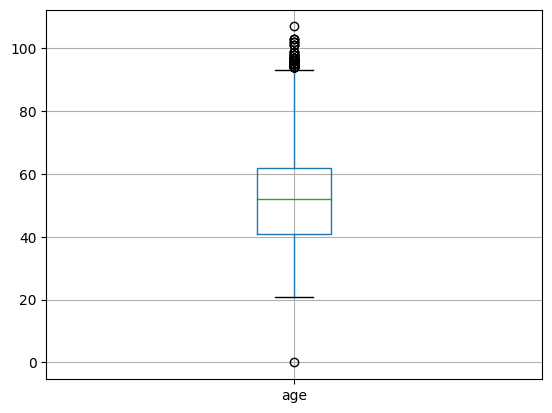

In [11]:
#对于age属性绘制箱线图
box2 = df.iloc[:,[2]] #age
print(box2.boxplot())
plt.show()
# 此外，我们发现在age有一个为0的样本，不符合常识，应同样作为异常值舍弃。
# 同时，我们看出，异常值普遍存在且聚集，因此我们后续会使用WOE编码以降低异常值的影响。

In [12]:
# 直接通过索引条件判断异常值，并对label做调整，使得好客户为1，坏客户为0.
df = df[df['30-59days']<90] #删除异常值(样本量较少或不合理时)
df = df[df['age']>0]

In [13]:
df['label'] = 1- df['label'] #对label取反，使优质客户为1，风险客户为0

<AxesSubplot:xlabel='MonthlyIncome', ylabel='Density'>

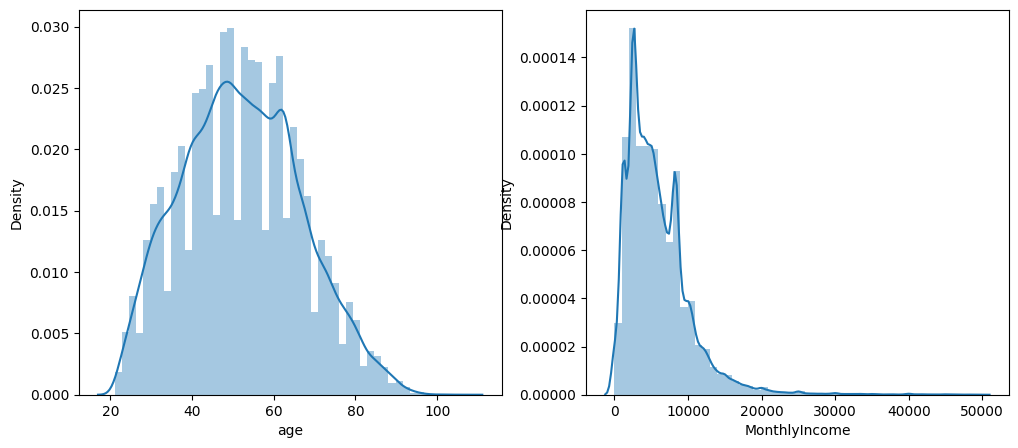

In [14]:
# 对数据进行探索性数据分析（Exploratory Data Analysis），可以进行单变量EDA，也可以多变量EDA。
# 首先以连续变量age和MonthlyIncome为例，作出直方图。
# %matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
age = df['age']
sns.distplot(age, ax=axes[0])
mi = df[df['MonthlyIncome']<50000]['MonthlyIncome'] # 使图更直观，将x轴范围限定在50000以内
sns.distplot(mi, ax=axes[1])
# 大概符合正态分布，符合逻辑回归模型的一般假设。


<AxesSubplot:>

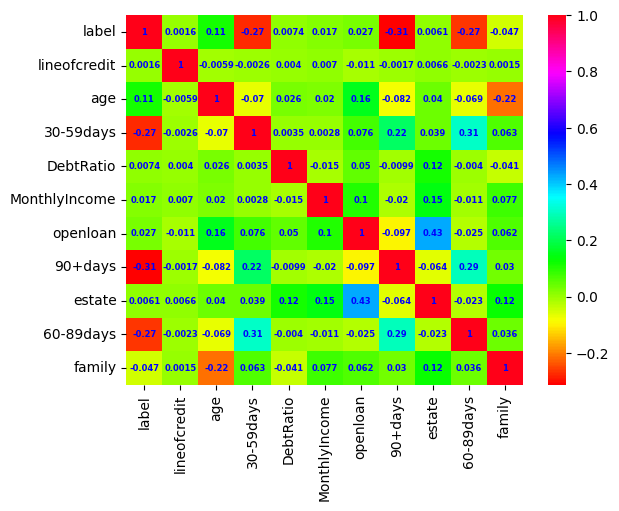

In [15]:
# 检验变量之间的相关性，如果自变量之间具有强相关性，会影响模型的准确性，需要重点关注，提取特征时需要保留。
corr = df.corr()
plt.figure() 
#heatmap参数说明
'''
corr：相关性矩阵。
annot=True：在每个热力图单元格中显示相关性值。
cmap='hsv'：设置颜色映射为 'hsv' 颜色映射。
annot_kws={'size':6,'weight':'bold','color':'blue'}：设置注释（相关性值）的属性，包括文本大小、加粗和颜色。
'''
sns.heatmap(corr, annot=True, cmap='hsv',
            annot_kws={'size':6,'weight':'bold','color':'blue'})
#1）各变量之间的相关性较小。后续逻辑回归可认为不存在多重共线性问题； 
#2）30-59days, 60-89days, 90+days对我们要预测的label 有较强的相关性。

In [16]:
# 将数据按照7:3分为训练集和测试集。
y = df.iloc[:,0]
X = df.iloc[:,1:]
train_X, test_X, train_y,test_y = train_test_split(X, y, test_size=0.3, random_state=0)

In [17]:
#特征工程
# WOE（Weight of Evidence）是一种在信用评分建模和风险评估中常用的统计方法，用于衡量一个特征对于目标变量的预测能力。
# 它将每个特征的不同取值映射到一个权重，这个权重表示了该特征在不同取值下对目标变量的影响程度。
# 可以处理缺失值、处理连续型和分类型特征，同时具有较强的解释性，降低异常值的影响。

# WOE=ln( Bad Events in the Bin / Good Events in the Bin)
# 分子表示在一个箱内的好客户（正样本）的分布，分母表示在一个箱内的坏客户（负样本）的分布。
# 通过对比WOE的值，我们可以了解到某个分箱内的样本对于目标变量的影响程度。WOE越大，表示该箱内的样本越有助于区分正负样本。
# IV（Information Value）是所有箱的WOE值加权求和的结果，用于评估整个变量的预测能力：
# IVi=( Bad Events in the Bin - Good Events in the Bin)*WOE i
# IV=SUM(IVi)
# 在实际建模中，一个变量的IV值可以用于判断其对目标变量的预测能力。通常，I值的范围是:
# < 0.02:没有预测能力
# 0.02-0.1:弱预测能力
# ·0.1-0.3:中等预测能力
# ·0.3-0.5:强预测能力
# >0.5:可疑，可能存在问题

# woe_value 函数的主要作用是计算每个分箱的WOE（Weight of Evidence）值和IV（Information Value）值。
# Bucket 在这里是分箱的标志位。
def woe_value(d1):
    d2=d1.groupby('Bucket', as_index=True) #使用 groupby 函数将数据按照 'Bucket' 列的值(已标记的分箱)进行分组，as_index=True 表示分组的结果会以 'Bucket' 作为索引。
    good=train_y.sum()#计算为1的好样本，之前已经把优质客户的Label（即y）变为1
    bad=train_y.count()-good# 计算为0的样本
    # d3=pd.DataFrame(d2.X.min()) #创建一个DataFrame d3，用来存储分箱后的统计信息。.X.min() 表示每个分箱区间的最小值
    d3=pd.DataFrame(d2.X.min(), columns=['min']) #创建一个DataFrame d3，用来存储分箱后的统计信息。.X.min() 表示每个分箱区间的最小值
    # print(f"d2={d2.head()}")
    # print(f"d2.X={d2.X.head()}")
    # print(f"d3={d3.head()}")
    
    # print(f"d3:\n{d3.head()}")
    # d3['min']=d2.min().X #将每个分箱区间的最小值加入到 d3 的 'min' 列中
    
    # print(f"after +min d3:\n{d3.head()}")
    d3['max']=d2.max().X #将每个分箱区间的最大值加入到 d3 的 'max' 列中
    d3['sum']=d2.sum().Y #使用 sum() 函数计算每个分箱区间内目标变量为正例的数量，并将结果加入到 d3 的 'sum' 列中
    d3['total']=d2.count().Y#总样本数
    d3['goodattribute']=d3['sum']/good #每个分箱y=1在所有样本为1的占比
    d3['badattribute']=(d3['total']-d3['sum'])/bad#每个分箱y=0在所有为0的占比
    d3['woe']=np.log(d3['goodattribute']/d3['badattribute'])#计算每个分箱的woe值
    
    # print(f"total d3:\n{d3.head()}")
    iv=((d3['goodattribute']-d3['badattribute'])*d3['woe']).sum() #计算IV值，衡量WOE编码的预测能力。
    # d4=(d3.sort_index(by='min')).reset_index(drop=True) #对统计信息按照 'min' 列的值进行排序，并重置索引。
    d4 = d3.sort_values(by='min').reset_index(drop=True)

    woe=list(d4['woe'].round(3)) #将排序后的WOE值保存到列表中，保留三位小数
    return d4, iv, woe

In [18]:
def mono_bin(Y, X, n=10):# 最优分段函数  Y:目标变量 label, X:一列；n是分箱的个数，默认10
    r=0
    # 使用循环寻找每个属性最优分箱
    while np.abs(r)<1:#spearman系数接近于1，表示模型更好地捕捉了特征和目标变量之间的正/负相关关系
        # 先将特征 X 和目标变量 Y 进行n等深分箱操作
        d1 = pd.DataFrame({"X":X, "Y":Y, "Bucket": pd.qcut(X,n)})
        d2 = d1.groupby('Bucket', as_index=True) # 按bucket分组
        
        # 计算每个分箱区间均值和y的Spearman 相关系数：斯皮尔曼等级相关系数
        #Spearman相关系数的取值范围为-1到1，负相关到正相关
        
        #Scipy 库中spearmanr()方法返回一个包含斯皮尔曼相关系数和p-value的元组。
        #r表示斯皮尔曼相关系数
        #p-value（p-值）：表示在原假设（两个变量之间没有相关性）下，观察到的Spearman相关系数或更极端的值的概率。如果p-value足够小，我们有足够的证据拒绝原假设。
        r,p = stats.spearmanr(d2.mean().X,d2.mean().Y)     
        # print(f"n={n},r={r}")
        n = n-1
    #分箱矩阵传入
    d4,iv,woe = woe_value(d1)  #利用最佳分箱数完成的分箱矩阵d1,求woe,iv
    
    # 计算切点 cut
    cut = []
    cut.append(float('-inf')) #在列表的开头添加负无穷，表示第一个分箱的下边界是负无穷。
    for i in range(1,n+1): #使用循环从1到n（分箱数），计算相应的分位数。
        qua=X.quantile(i/(n+1)) # Pandas 中的quantile() 方法，用于计算指定分位数的值。
        cut.append(round(qua,4)) #添加每个分箱上限
    cut.append(float('+inf')) #最后分箱的上限是正无穷 
    # 返回分箱统计信息、IV 值、切点 cut列表和 WOE 值列表
    return d4, iv, cut, woe

In [19]:
# 利用函数对连续变量lineofcredit，age，DebtRatio, MonthlyIncome分箱，返回需要的dataframe、iv值、切点 cut列表和 WOE 值列表
x1_d, x1_iv, x1_cut, x1_woe = mono_bin(train_y, train_X.lineofcredit)  #传入单列X，进行mono_bin分箱
x2_d, x2_iv, x2_cut, x2_woe = mono_bin(train_y, train_X.age)
x4_d, x4_iv, x4_cut, x4_woe = mono_bin(train_y, train_X.DebtRatio)
x5_d, x5_iv, x5_cut, x5_woe = mono_bin(train_y, train_X.MonthlyIncome)

In [20]:
# 其他的非连续型变量，则需要进行手动分箱（主要使用df的拼接操作），目标切点如下（切点可根据要求自行选择）：
#全部属性: label	lineofcredit	age	30-59days	DebtRatio	MonthlyIncome	openloan	90+days	estate	60-89days	family
#X3：30-59days	X6:openloan    X7:90+days        X8:estate          X9:60-89days      X10:family
from math import inf
x3_cut = [-inf, 0, 1, 3, 5, +inf] 
x6_cut = [-inf, 1, 2, 3, 5, +inf]
x7_cut = [-inf, 0, 1, 3, 5, +inf] 
x8_cut = [-inf, 0, 1, 2, 3, +inf] 
x9_cut = [-inf, 0, 1, 3, +inf] 
x10_cut = [-inf, 0, 1, 2, 3, 5, +inf] 

In [21]:
# 以x3为例，其余的离散变量同理。
# 先选择x3:30-59days和目标变量列，并改名为X和Y
d1=pd.DataFrame({'X':train_X["30-59days"],"Y":train_y})
# 手动添加bucket列且赋值为X
d1['Bucket'] = d1['X']
# 用loc函数做判断创建新的数据框，当属于对应区间时，给bucket列附上正确的范围
# 对于x3，我们希望它分成小于0，0-1，1-3，3-5和大于5。
d1_x1 = d1.loc[(d1['Bucket']<=0)]
d1_x1.loc[:,'Bucket']="(-inf,0]"
d1_x2 = d1.loc[(d1['Bucket']>0)&(d1['Bucket']<=1)]
d1_x2.loc[:,'Bucket']="(0,1]"
d1_x3 = d1.loc[(d1['Bucket']>1)&(d1['Bucket']<=3)]
d1_x3.loc[:,'Bucket']="(1,3]"
d1_x4 = d1.loc[(d1['Bucket']>3)&(d1['Bucket']<=5)]
d1_x4.loc[:,'Bucket']="(3,5]"
d1_x5 = d1.loc[d1['Bucket']>5]
d1_x5.loc[:,'Bucket']="(5,+inf)"

# 最后用concat函数将所有的正确处理后的数据框拼接起来，分箱结束
d1=pd.concat([d1_x1,d1_x2,d1_x3,d1_x4,d1_x5])
#分箱完，用函数计算woe、iv值
x3_d, x3_iv, x3_woe = woe_value(d1)
# 变量的切点列表
x3_cut = [float('-inf'),0,1,3,5,float('+inf')]

In [22]:
#x6
d1=pd.DataFrame({'X':train_X["openloan"],"Y":train_y})
d1['Bucket'] = d1['X']
d1_x1 = d1.loc[(d1['Bucket']<=1)]
d1_x1.loc[:,'Bucket']="(-inf,1]"
d1_x2 = d1.loc[(d1['Bucket']>1)&(d1['Bucket']<=2)]
d1_x2.loc[:,'Bucket']="(1,2]"
d1_x3 = d1.loc[(d1['Bucket']>2)&(d1['Bucket']<=3)]
d1_x3.loc[:,'Bucket']="(2,3]"
d1_x4 = d1.loc[(d1['Bucket']>3)&(d1['Bucket']<=5)]
d1_x4.loc[:,'Bucket']="(3,5]"
d1_x5 = d1.loc[d1['Bucket']>5]
d1_x5.loc[:,'Bucket']="(5,+inf)"
d1=pd.concat([d1_x1,d1_x2,d1_x3,d1_x4,d1_x5])
x6_d, x6_iv, x6_woe = woe_value(d1)
x6_cut = [float('-inf'),0,1,3,5,float('+inf')]
#x7
d1=pd.DataFrame({'X':train_X["90+days"],"Y":train_y})
d1['Bucket'] = d1['X']
d1_x1 = d1.loc[(d1['Bucket']<=0)]
d1_x1.loc[:,'Bucket']="(-inf,0]"
d1_x2 = d1.loc[(d1['Bucket']>0)&(d1['Bucket']<=1)]
d1_x2.loc[:,'Bucket']="(0,1]"
d1_x3 = d1.loc[(d1['Bucket']>1)&(d1['Bucket']<=3)]
d1_x3.loc[:,'Bucket']="(1,3]"
d1_x4 = d1.loc[(d1['Bucket']>3)&(d1['Bucket']<=5)]
d1_x4.loc[:,'Bucket']="(3,5]"
d1_x5 = d1.loc[d1['Bucket']>5]
d1_x5.loc[:,'Bucket']="(5,+inf)"
d1=pd.concat([d1_x1,d1_x2,d1_x3,d1_x4,d1_x5])
x7_d, x7_iv, x7_woe = woe_value(d1)
x7_cut = [float('-inf'),0,1,3,5,float('+inf')]
#x8
d1=pd.DataFrame({'X':train_X["estate"],"Y":train_y})
d1['Bucket'] = d1['X']
d1_x1 = d1.loc[(d1['Bucket']<=0)]
d1_x1.loc[:,'Bucket']="(-inf,0]"
d1_x2 = d1.loc[(d1['Bucket']>0)&(d1['Bucket']<=1)]
d1_x2.loc[:,'Bucket']="(0,1]"
d1_x3 = d1.loc[(d1['Bucket']>1)&(d1['Bucket']<=2)]
d1_x3.loc[:,'Bucket']="(1,2]"
d1_x4 = d1.loc[(d1['Bucket']>2)&(d1['Bucket']<=3)]
d1_x4.loc[:,'Bucket']="(2,3]"
d1_x5 = d1.loc[d1['Bucket']>3]
d1_x5.loc[:,'Bucket']="(3,+inf)"
d1=pd.concat([d1_x1,d1_x2,d1_x3,d1_x4,d1_x5])
x8_d, x8_iv, x8_woe = woe_value(d1)
x8_cut = [float('-inf'),0,1,2,3,float('+inf')]
#x9
d1=pd.DataFrame({'X':train_X["60-89days"],"Y":train_y})
d1['Bucket'] = d1['X']
d1_x1 = d1.loc[(d1['Bucket']<=0)]
d1_x1.loc[:,'Bucket']="(-inf,0]"
d1_x2 = d1.loc[(d1['Bucket']>0)&(d1['Bucket']<=1)]
d1_x2.loc[:,'Bucket']="(0,1]"
d1_x3 = d1.loc[(d1['Bucket']>1)&(d1['Bucket']<=3)]
d1_x3.loc[:,'Bucket']="(1,3]"
d1_x4 = d1.loc[d1['Bucket']>3]
d1_x4.loc[:,'Bucket']="(3,+inf)"
d1=pd.concat([d1_x1,d1_x2,d1_x3,d1_x4])
x9_d, x9_iv, x9_woe = woe_value(d1)
x9_cut = [float('-inf'),0,1,3,float('+inf')]
#x10
d1=pd.DataFrame({'X':train_X["family"],"Y":train_y})
d1['Bucket'] = d1['X']
d1_x1 = d1.loc[(d1['Bucket']<=0)]
d1_x1.loc[:,'Bucket']="(-inf,0]"
d1_x2 = d1.loc[(d1['Bucket']>0)&(d1['Bucket']<=1)]
d1_x2.loc[:,'Bucket']="(0,1]"
d1_x3 = d1.loc[(d1['Bucket']>1)&(d1['Bucket']<=2)]
d1_x3.loc[:,'Bucket']="(1,2]"
d1_x4 = d1.loc[(d1['Bucket']>2)&(d1['Bucket']<=3)]
d1_x4.loc[:,'Bucket']="(2,3]"
d1_x5 = d1.loc[(d1['Bucket']>3)&(d1['Bucket']<=5)]
d1_x5.loc[:,'Bucket']="(3,5]"
d1_x6 = d1.loc[d1['Bucket']>5]
d1_x6.loc[:,'Bucket']="(5,+inf)"
d1=pd.concat([d1_x1,d1_x2,d1_x3,d1_x4,d1_x5,d1_x6])
x10_d, x10_iv, x10_woe = woe_value(d1)
x10_cut = [float('-inf'),0,1,2,3,5,float('+inf')]

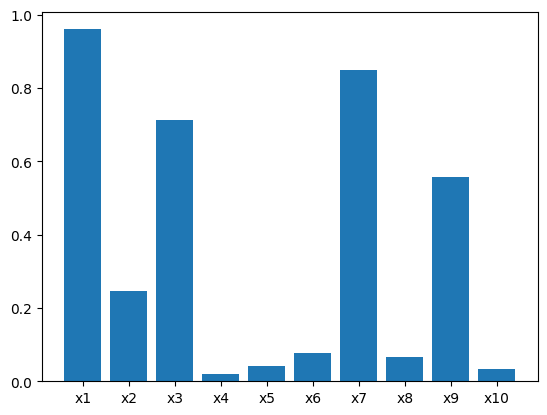

In [23]:
# 对所有的自变量，我们已经算出IV值，创建一个空列表，将所有自变量的iv添加进去，用条形图可视化展示。
info_value=[]
info_value.append(x1_iv)
info_value.append(x2_iv)
info_value.append(x3_iv)
info_value.append(x4_iv)
info_value.append(x5_iv)
info_value.append(x6_iv)
info_value.append(x7_iv)
info_value.append(x8_iv)
info_value.append(x9_iv)
info_value.append(x10_iv)
index=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10'] #按序对应变量
index_num = range(len(index))
ax = plt.bar(index_num, info_value, tick_label = index)
# 全部属性: label	lineofcredit	age	30-59days	DebtRatio	MonthlyIncome	openloan	90+days	estate	60-89days	family
# DebtRatio(X4), MonthlyIncome(X5), openloan(X6)和family(x10)的iv值明显较低。
# 故最终选择lineofcredit (x1), age (x2), 30-59days (x3), 90+days (x7), 60-89days (x9)变量建模
# 【与前述热力图展现的x3,x7,x9与label的相关性也一致】。

In [24]:
 # 逻辑回归（Logistic Regression）,因变量是label（0/1分类好客户和坏客户），自变量是由上述iv值选择出来的变量。
# 我们可以把WOE编码转换看作为一种数据标准化，可以降低异常值和量纲不同的影响。
# 由于我们前面已经得到每个变量的woe值列表和切点列表

print(f"x1_woe:{x1_woe}")#X1各分箱区间的woe值
print(f"x1_cut:{x1_cut}")#x1的分箱区间


x1_woe:[1.283, 1.193, 0.298, -1.094]
x1_cut:[-inf, 0.0312, 0.1579, 0.5581, inf]


In [25]:
train_X.head(5)

,lineofcredit,age,30-59days,DebtRatio,MonthlyIncome,openloan,90+days,estate,60-89days,family
72677,0.116603,40,0,0.424877,2435.0,7,0,0,0,2.0
115023,0.411956,48,0,0.265566,7933.0,9,0,2,0,2.0
16270,0.096891,61,0,1.036847,3500.0,19,0,2,0,0.0
107493,0.046594,65,0,0.075840,13000.0,7,0,1,0,1.0
140597,0.015649,81,0,0.000867,15000.0,7,0,0,0,0.0


In [26]:
# 函数trans_woe（）的作用是把每一列中对应分箱中的数值替换为该分箱的woe数值
def trans_woe(var,var_name,x_woe,x_cut):    #传入一个df.series, 变量名，前面算的woe值列表和对应的切点列表
    woe_name=var_name+'_woe'
    for i in range(len(x_woe)):
        if i == 0:
            var.loc[(var[var_name]<=x_cut[i+1]),woe_name]= x_woe[i]
        elif (i>0) and(i<=len(x_woe)-2):
            var.loc[((var[var_name]>x_cut[i])&
                     (var[var_name]<=x_cut[i+1])),woe_name]=x_woe[i]
        else: 
            var.loc[(var[var_name]>x_cut[len(x_woe)-1]),woe_name] = x_woe[len(x_woe)-1]
    return var
x1_name = 'lineofcredit'
x2_name = 'age'
x3_name = '30-59days'
x7_name = '90+days'
x9_name = '60-89days'
train_X = trans_woe(train_X,x1_name,x1_woe,x1_cut)
train_X = trans_woe(train_X,x2_name,x2_woe,x2_cut)              
train_X = trans_woe(train_X,x3_name,x3_woe,x3_cut)
train_X = trans_woe(train_X,x7_name,x7_woe,x7_cut)
train_X = trans_woe(train_X,x9_name,x9_woe,x9_cut)
train_X = train_X.iloc[:,-5:]#仅保留新生成的5列woe
train_X.head(5)
# 我们可以发现样本的某些变量可能与其他样本具有相同的woe编码，这是因为他们属于同一个bucket

,lineofcredit_woe,age_woe,30-59days_woe,90+days_woe,60-89days_woe
72677,1.193,-0.391,0.526,0.379,0.274
115023,0.298,-0.199,0.526,0.379,0.274
16270,1.193,0.491,0.526,0.379,0.274
107493,1.193,0.935,0.526,0.379,0.274
140597,1.283,1.123,0.526,0.379,0.274


In [27]:
# 1.5.4.2.建立逻辑回归模型
X1=sm.add_constant(train_X) #在训练集 train_X 上添加一个常数列，用于模型拟合中的截距。
#在Scikit-learn中，逻辑回归模型的默认行为是包含截距项,所以无需手动添加
logit=sm.Logit(train_y,X1) #创建一个 Logistic 回归模型对象，将训练集特征 X1 和目标变量 train_y 传递给模型。
result=logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.186491
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:               101747
Model:                          Logit   Df Residuals:                   101741
Method:                           MLE   Df Model:                            5
Date:                Sat, 03 Feb 2024   Pseudo R-squ.:                  0.2410
Time:                        15:07:27   Log-Likelihood:                -18975.
converged:                       True   LL-Null:                       -25000.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.6084      0.015    171.840      0.000       2.579       2.638
lineofcredi

In [28]:
# 由系数p值<0.05可知，拒绝系数为0的原假设，该模型成立
# 在统计学中，我们经常使用显著性水平（Significance Level）来判断结果是否显著。常见的显著性水平是0.05，意味着我们接受的错误率为5%。
# 如果一个模型参数的p值小于0.05，我们通常会说这个参数是显著的，即我们有足够的信心认为这个参数对于解释因变量是有影响的。


# Dep. Variable（Dependent Variable）: 模型的因变量，也就是逻辑回归的目标变量。在这里，是'label'，可能代表二元分类问题中的某个类别。
# No. Observations（观测数）: 数据集中的观测数量，这里是101747。
# Model（模型）: 表示使用的模型类型，这里是Logit，即Logistic回归。
# Method（方法）: 用于估计模型参数的最大似然估计法（Maximum Likelihood Estimation，MLE）。
# Date（日期） 和 Time（时间）: 显示模型拟合的日期和时间。
# converged（是否收敛）: 表示模型是否收敛到一个稳定的解。如果为True，表示模型已经成功收敛。
# Covariance Type（协方差类型）: 表示协方差矩阵的估计方法，这里是非鲁棒估计（nonrobust）。
# Df Residuals（残差的自由度）: 模型残差的自由度，即观测数减去模型参数的数量。在这里是101741。
# Df Model（模型的自由度）: 模型中估计的参数数量，这里是5.
# Pseudo R-squ.（伪R方）: 用于度量模型的拟合程度。在这里，伪R方为0.2410，表示模型解释了一定比例的方差。
# Log-Likelihood（对数似然）: 给定模型下，观测数据的对数似然值，这里是-18975。
# LL-Null（零模型下的对数似然）: 在只包含截距的零模型下的对数似然值，用于计算伪R方。这里是-25000。
# LLR p-value（似然比检验的p值）: 用于检验模型的显著性。如果这个值小于显著性水平（通常是0.05），我们可以拒绝零假设，即模型是显著的。


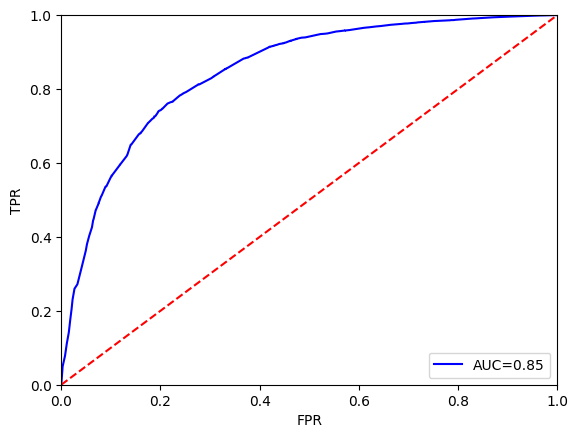

In [29]:
# 用前面划分的测试集数据，用ROC曲线进行模型评估。
#首先测试集数据进行woe转化（训练的模型是在woe编码后的模型）
test_X = trans_woe(test_X, x1_name, x1_woe, x1_cut)
test_X = trans_woe(test_X, x2_name, x2_woe, x2_cut)
test_X = trans_woe(test_X, x3_name, x3_woe, x3_cut)
test_X = trans_woe(test_X, x7_name, x7_woe, x7_cut)
test_X = trans_woe(test_X, x9_name, x9_woe, x9_cut)
test_X = test_X.iloc[:,-5:]

#拟合模型，画出ROC曲线得到AUC值
X3 = sm.add_constant(test_X)#在测试集 test_X 上添加一个常数列
re = result.predict(X3) #使用拟合好的 Logistic 回归模型 result 在测试集上进行预测，得到预测结果

#计算 ROC 曲线上的假正率（FPR）、真正率（TPR）和相应的阈值。
fpr, tpr, threshold = metrics.roc_curve(test_y,re)

# AUC值（Area Under the Curve）。AUC值是一个衡量模型性能的指标，取值范围在0到1之间，值越接近1表示模型性能越好。
# 一般来说，AUC值越高，模型对正负样本的区分能力越强。
rocauc = metrics.auc(fpr, tpr)#计算 ROC 曲线下的面积，即 AUC 值

plt.plot(fpr, tpr, 'b', label = 'AUC=%0.2f'%rocauc)#绘制 ROC 曲线，将 AUC 值显示在图例中。
plt.legend(loc = 'lower right')#在图中显示图例，位置为右下角
plt.plot([0,1],[0,1],'r--')#绘制对角线，代表随机分类的情况
plt.xlim([0,1])#设置 x 轴和 y 轴的范围为 0 到 1，确保曲线在合适的范围内显示
plt.ylim([0,1])
plt.ylabel('TPR')#设置 x 轴和 y 轴的标签
plt.xlabel('FPR')#显示绘制的 ROC 曲线图
plt.show()
# AUC值为0.85，说明该模型的预测效果不错。

In [30]:
# 在二分类问题中，模型通常会输出一个连续的概率值或分数，表示样本属于正类别的可能性。为了将这个连续的输出映射为二分类的预测结果，需要设定一个阈值（Threshold）。
# 当模型输出的概率值超过这个阈值时，将样本预测为正类别；否则，预测为负类别。
# threshold 是一个一维数组（或列表），其中包含了在计算 ROC 曲线时使用的各个阈值的取值。
# 每个元素表示一个阈值，用于将模型的连续输出映射为二分类的预测结果。这些阈值构成了 ROC 曲线上的不同点，
# 通过在不同阈值下计算假正率（FPR）和真正率（TPR），我们可以绘制出 ROC 曲线，从而评估模型性能。
